In [2]:
from matplotlib import pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import os

In [3]:
once_per = 23
def parse_annotation_ua(ann_dir, img_dir, labels=[], weather_filter=['sunny', 'night', 'cloudy', 'rainy']):
    all_imgs = []
    seen_labels = {}
    for xml_anot in os.listdir(ann_dir):
        counter = -1
        tree = ET.parse(ann_dir + xml_anot)
        weather = tree.find('sequence_attribute').attrib['sence_weather']
        if weather in weather_filter:
            for elem in tree.findall('frame'):
                counter += 1
                if counter%once_per != 0:
                    continue

                frame_index = elem.attrib['num']
                obj = []
                for target in list(elem.find('target_list')):
                    box = target.find('box')
                    xmin = int(round(float(box.attrib['left'])))
                    ymin = int(round(float(box.attrib['top'])))
                    xmax = xmin + int(round(float(box.attrib['width'])))
                    ymax = ymin + int(round(float(box.attrib['height'])))
                    key = target.find('attribute').attrib['vehicle_type']
                    
                    if key in seen_labels:
                        seen_labels[key] += 1
                    else:
                        seen_labels[key] = 1
                    
                    if key in labels or len(labels) == 0:
                        obj.append({'name': key, 'xmax': xmax, 'xmin': xmin, 'ymax': ymax, 'ymin': ymin})
                
                img = {
                    'object': obj,
                    'filename': img_dir + xml_anot[:-4] + '/img{}.jpg'.format(str(frame_index).zfill(5)),
                    'height': 540,
                    'width': 960
                }
                all_imgs += [img]
    return all_imgs, seen_labels

In [4]:
labels = ['bicycle','bus','car','motorbike']
ua_imgs, ua_all_labels =parse_annotation_ua('./data/ua_deteract/DETRAC-Train-Annotations-XML/', './data/ua_deteract/Insight-MVT_Annotation_Train/', labels, ['night'])

In [5]:
len(ua_imgs)

1000

In [6]:
map_ua = {key:0 for key in labels}
for img in ua_imgs:
    for obj in img['object']:
        if obj['name'] in labels:
            map_ua += 1
print(map_ua)

{'car': 4032, 'bus': 375, 'van': 250, 'others': 39}

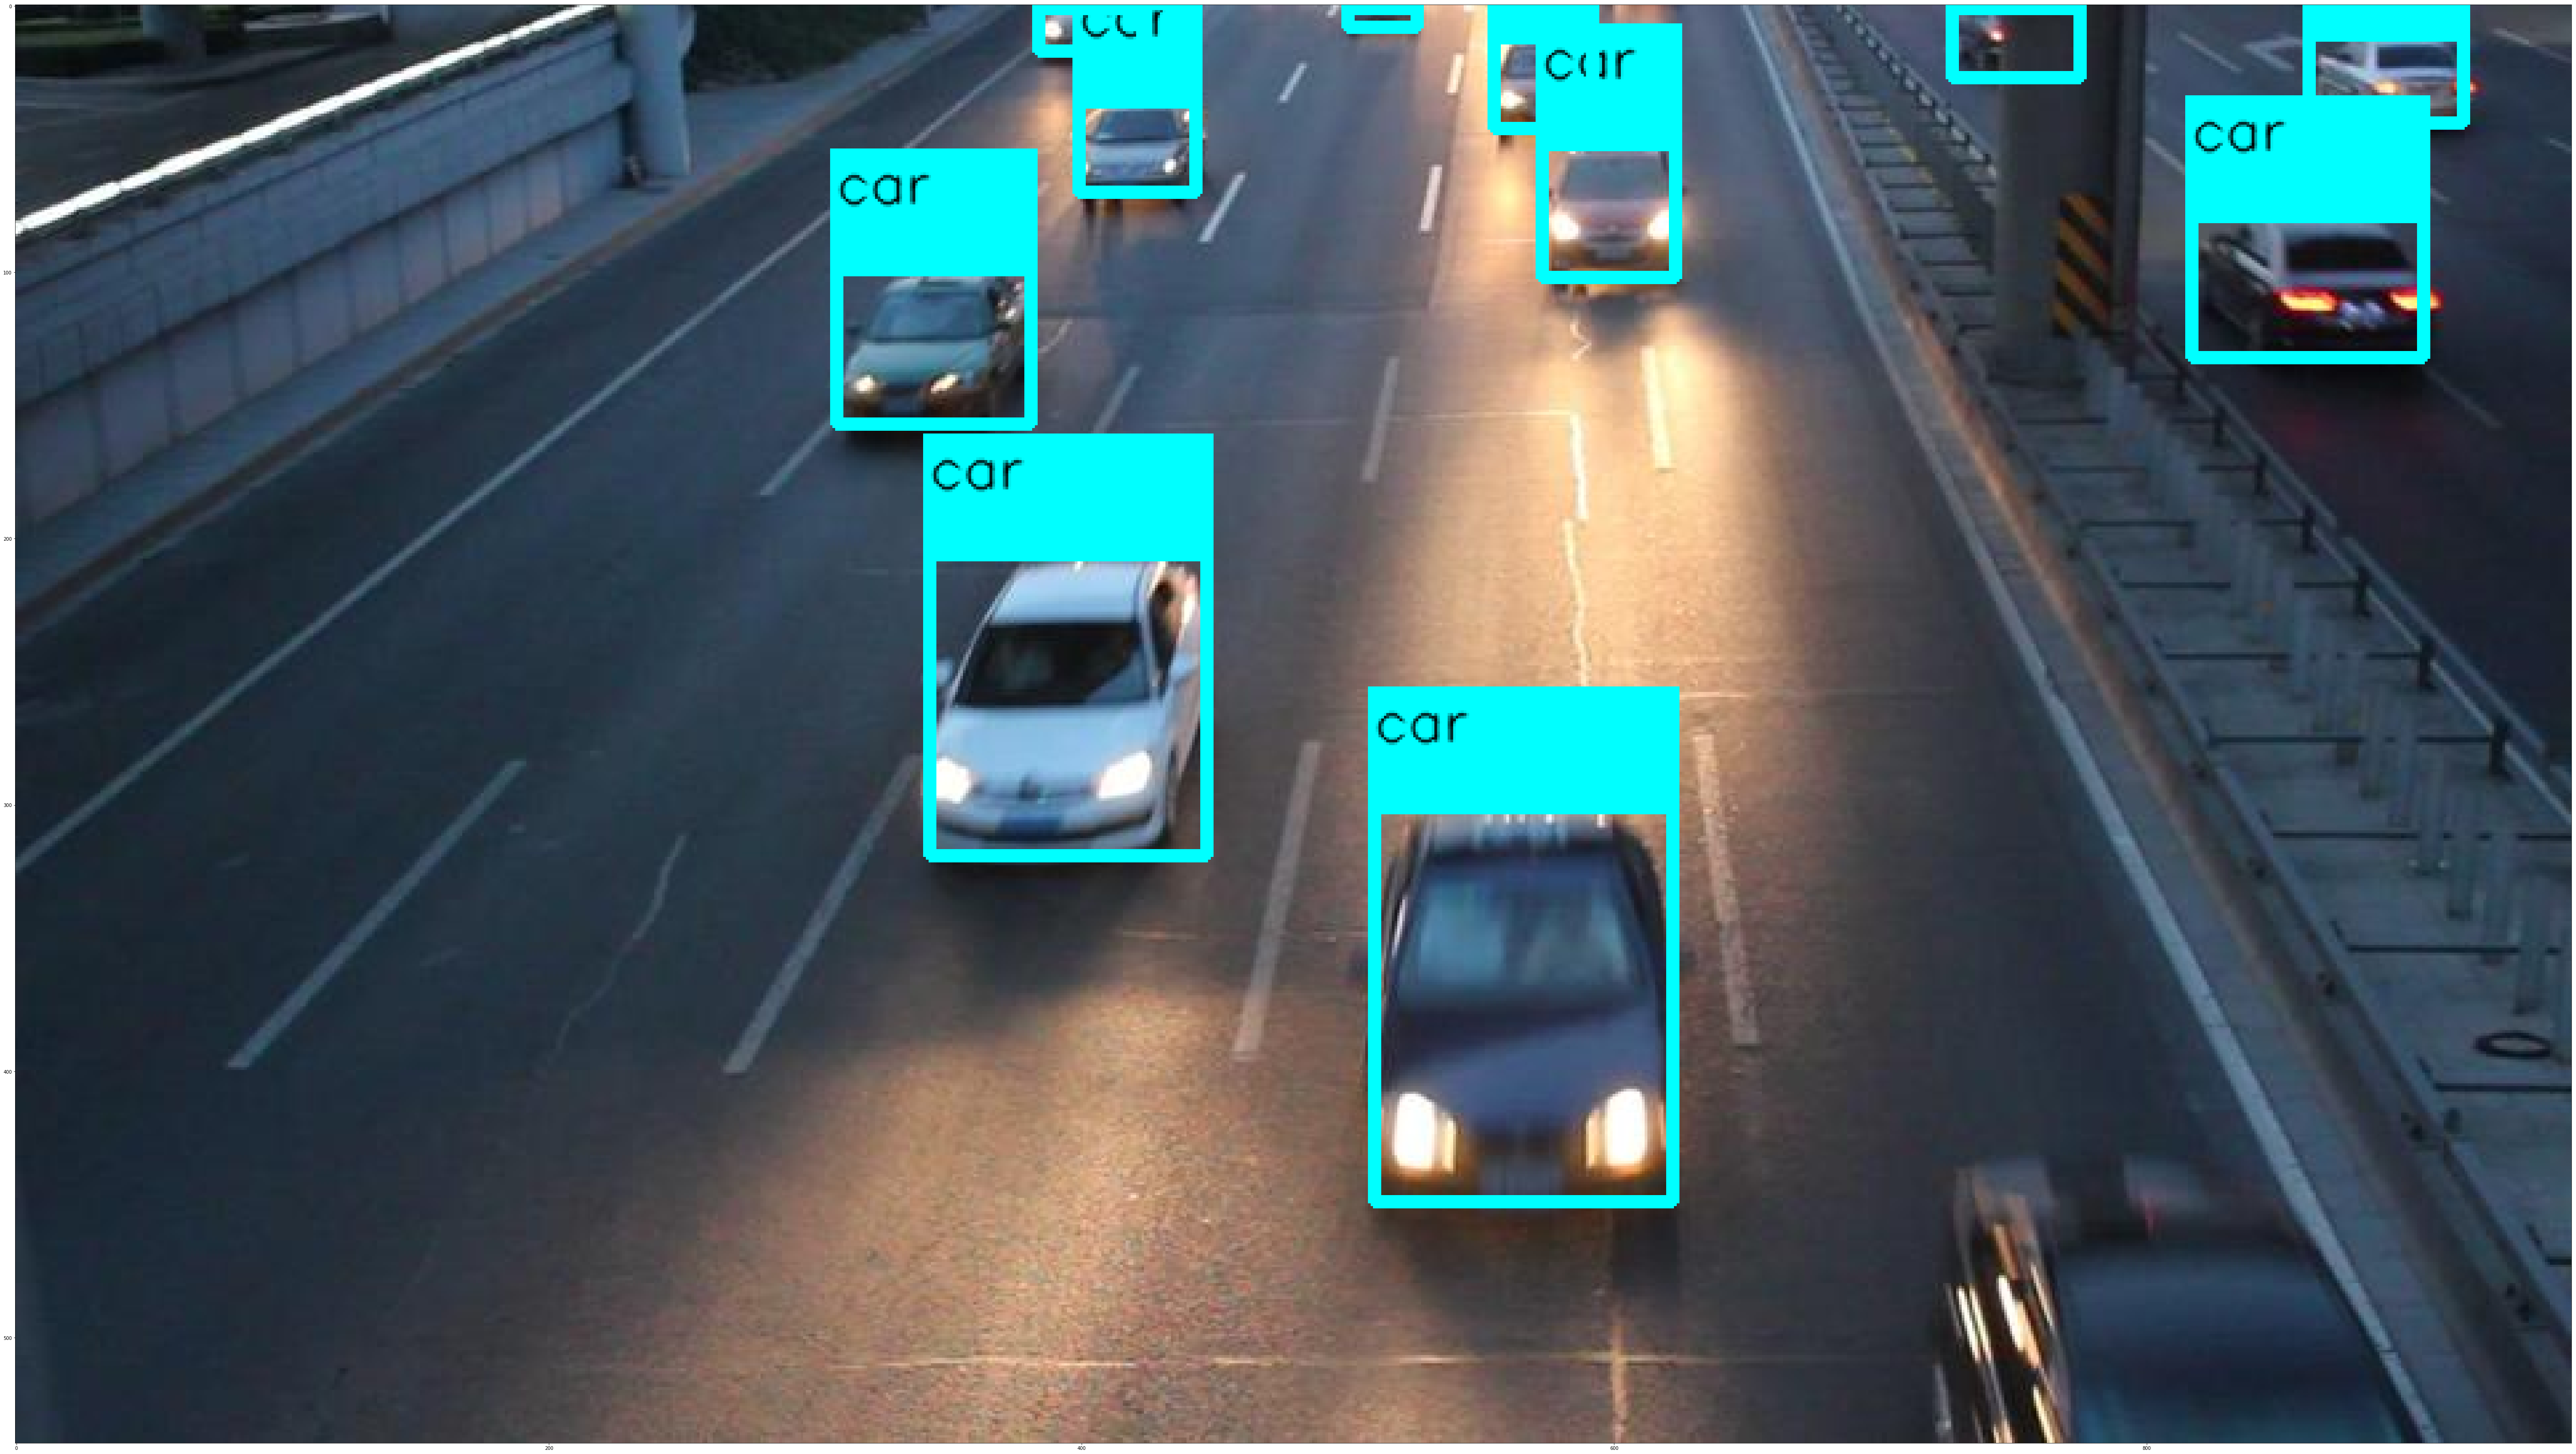

In [7]:
#SANITY CHECK

import cv2
import matplotlib.pyplot as plt
from lib.helpers import draw_box_label
img = ua_imgs[100]
test_1 = cv2.imread(img['filename'])
test_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2RGB)
for obj in img['object']:
    test_1 = draw_box_label(test_1, [obj['ymin'], obj['xmin'], obj['ymax'], obj['xmax']], obj['name'], box_color=(0, 255, 255),show_label=True)
plt.figure(figsize=(100,100))
plt.imshow(test_1)
plt.show()

In [2]:
import numpy as np
from lib.detector.YOLO.train.preprocessing import parse_annotation
labels = ['bicycle','bus','car','motorbike']
voc_imgs, voc_labels = parse_annotation('./data/voc/anot/','./data/voc/image/', labels)

# train_valid_split = int(0.8*len(train_imgs))
# np.random.shuffle(train_imgs)

# valid_imgs = train_imgs[train_valid_split:]
# train_imgs = train_imgs[:train_valid_split]

In [4]:
print(len(voc_imgs))

2512


In [7]:
print({key:voc_labels[key] for key in labels})

{'bicycle': 837, 'bus': 685, 'car': 2492, 'motorbike': 801}


In [8]:
# # {'object': [{'name': 'car', 'xmax': 500, 'xmin': 295, 'ymax': 238, 'ymin': 132}, {'name': 'car', 'xmax': 231, 'xmin': 1, 'ymax': 246, 'ymin': 86}], 'filename': './data/voc/image/2010_000508.jpg', 'height': 375, 'width': 500}
# import random

# oversampling = []
# for _img in voc_imgs:
#     for obj in _img['object']:
#         if obj['name'] == 'motorbike' and random.choice([True, False]):
#             oversampling.append(_img)
#             break

# for _img in voc_imgs:
#     for obj in _img['object']:
#         if obj['name'] == 'bus' and random.choice([True, False]):
#             oversampling.append(_img)
#             break
# print(oversampling[0])
# len(oversampling)

{'object': [{'name': 'motorbike', 'xmin': 54, 'ymin': 25, 'xmax': 454, 'ymax': 315}, {'name': 'motorbike', 'xmin': 318, 'ymin': 37, 'xmax': 489, 'ymax': 161}], 'filename': './data/voc/image/2007_000364.jpg', 'width': 500, 'height': 375}


605

In [9]:
# voc_imgs += voc_imgs
# len(voc_imgs)

4058

In [10]:
# len(ua_imgs)

1000

In [9]:
voc_train_valid_split = int(0.8*len(voc_imgs))
np.random.shuffle(voc_imgs)

valid_imgs = voc_imgs[voc_train_valid_split:]
train_imgs = voc_imgs[:voc_train_valid_split]

count_valid = {key:0 for key in labels}
for dat in valid_imgs:
    for obj in dat['object']:
        count_valid[obj['name']] += 1

train_valid = {key:0 for key in labels}
for dat in train_imgs:
    for obj in dat['object']:
        train_valid[obj['name']] += 1
print(count_valid)
print(train_valid)
print("validation len: ", str(len(valid_imgs)))
print("train len: ", str(len(train_imgs)))

{'bicycle': 178, 'bus': 146, 'car': 520, 'motorbike': 150}
{'bicycle': 659, 'bus': 539, 'car': 1972, 'motorbike': 651}
validation len:  503
train len:  2009


In [11]:
np.random.shuffle(ua_imgs)
ua_choosen = ua_imgs[0:500]
print(len(ua_choosen))
ua_train_valid_split = int(0.8*len(ua_choosen))
valid_imgs += ua_choosen[ua_train_valid_split:]
train_imgs += ua_choosen[:ua_train_valid_split]
count_valid = {key:0 for key in labels}

count_valid = {key:0 for key in labels}
for dat in valid_imgs:
    for obj in dat['object']:
        count_valid[obj['name']] += 1

train_valid = {key:0 for key in labels}
for dat in train_imgs:
    for obj in dat['object']:
        train_valid[obj['name']] += 1
print(count_valid)
print(train_valid)
print("validation len: ", str(len(valid_imgs)))
print("train len: ", str(len(train_imgs)))

500
{'bicycle': 178, 'bus': 184, 'car': 905, 'motorbike': 150}
{'bicycle': 659, 'bus': 699, 'car': 3537, 'motorbike': 651}
validation len:  603
train len:  2409


In [10]:
print(train_imgs[0])

{'object': [{'name': 'car', 'xmax': 500, 'xmin': 474, 'ymax': 224, 'ymin': 182}], 'filename': './data/voc/image/2011_001080.jpg', 'height': 337, 'width': 500}


In [12]:
train_val_config = {'val': valid_imgs, 'train': train_imgs}

In [13]:
import json
with open('ua_voc_4.json', 'w') as fp:
    json.dump(train_val_config, fp, indent=4)

In [16]:
# Make sure the file is exist
!tail ua_voc_4.json

                    "ymax": 122,
                    "ymin": 102
                }
            ],
            "filename": "./data/ua_deteract/Insight-MVT_Annotation_Train/MVI_39861/img00415.jpg",
            "height": 540,
            "width": 960
        }
    ]
}

In [17]:
!head ua_voc_4.json

{
    "val": [
        {
            "object": [
                {
                    "name": "bus",
                    "xmax": 500,
                    "xmin": 414,
                    "ymax": 249,
                    "ymin": 181


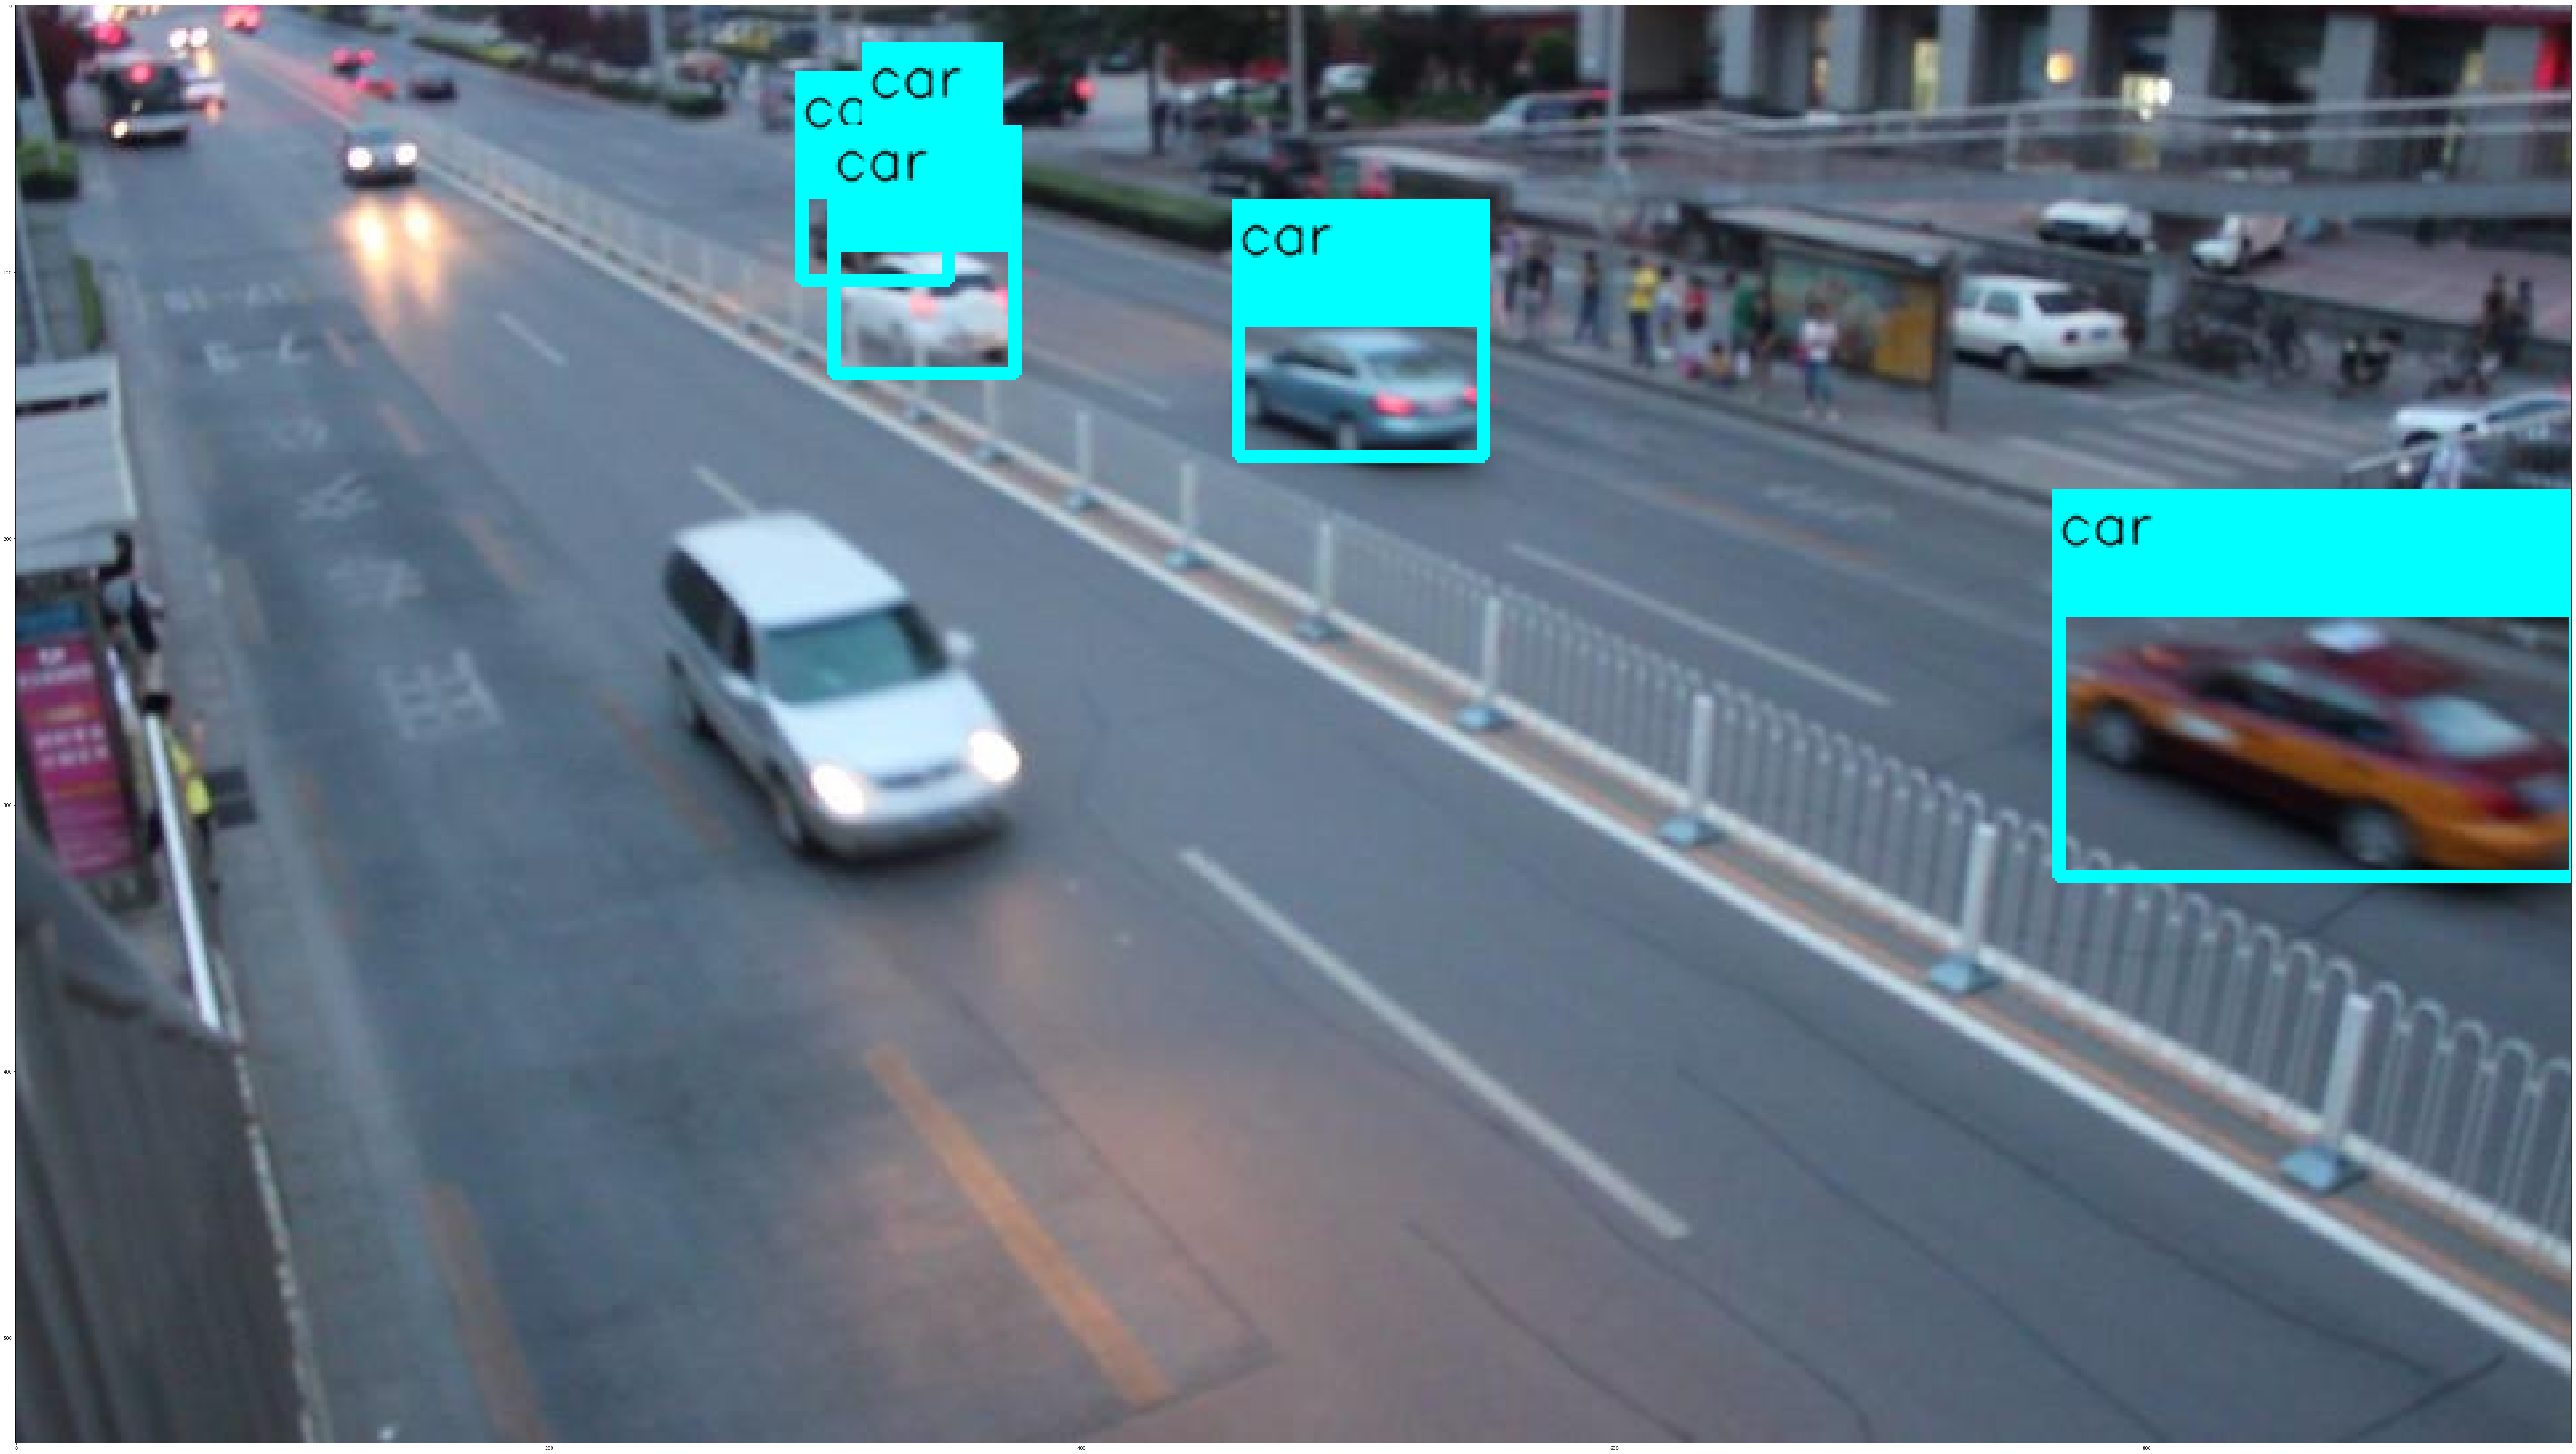

In [19]:
img = ua_imgs[250]
test_1 = cv2.imread(img['filename'])
test_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2RGB)
for obj in img['object']:
    test_1 = draw_box_label(test_1, [obj['ymin'], obj['xmin'], obj['ymax'], obj['xmax']], obj['name'], box_color=(0, 255, 255),show_label=True)
plt.figure(figsize=(100,100))
plt.imshow(test_1)
plt.show()

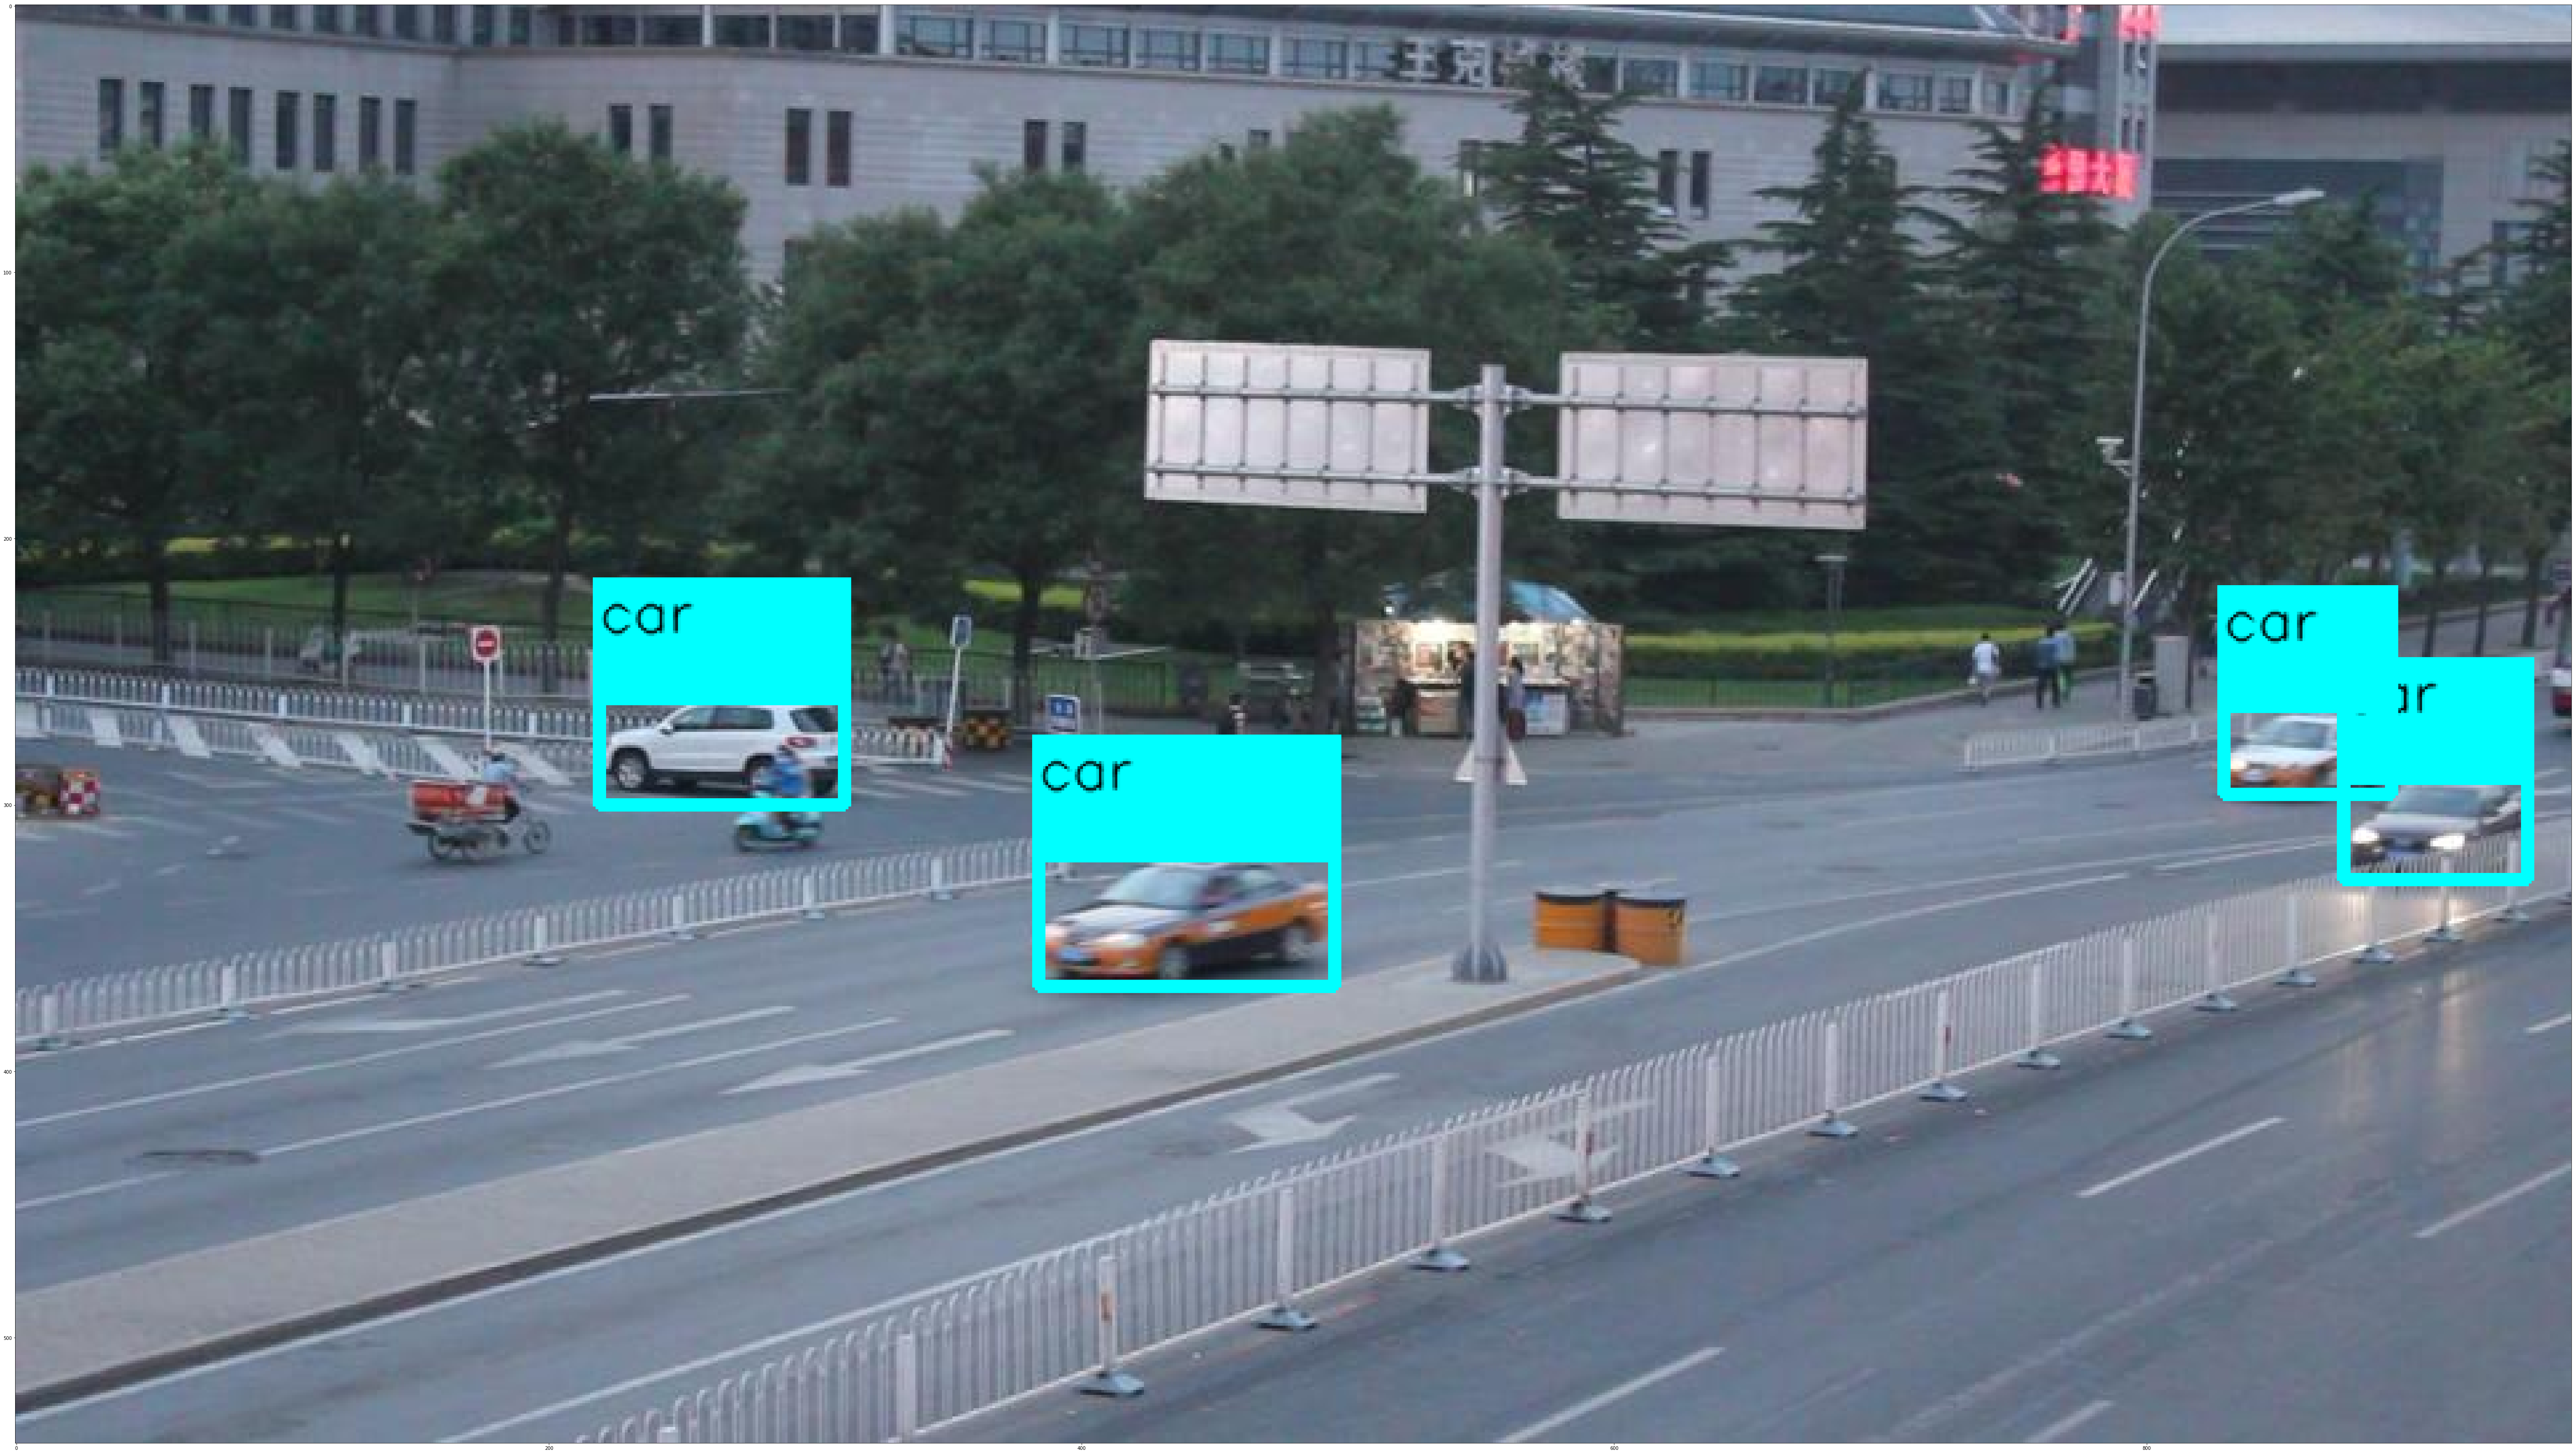

In [20]:
img = ua_imgs[123]
test_1 = cv2.imread(img['filename'])
test_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2RGB)
for obj in img['object']:
    test_1 = draw_box_label(test_1, [obj['ymin'], obj['xmin'], obj['ymax'], obj['xmax']], obj['name'], box_color=(0, 255, 255),show_label=True)
plt.figure(figsize=(100,100))
plt.imshow(test_1)
plt.show()

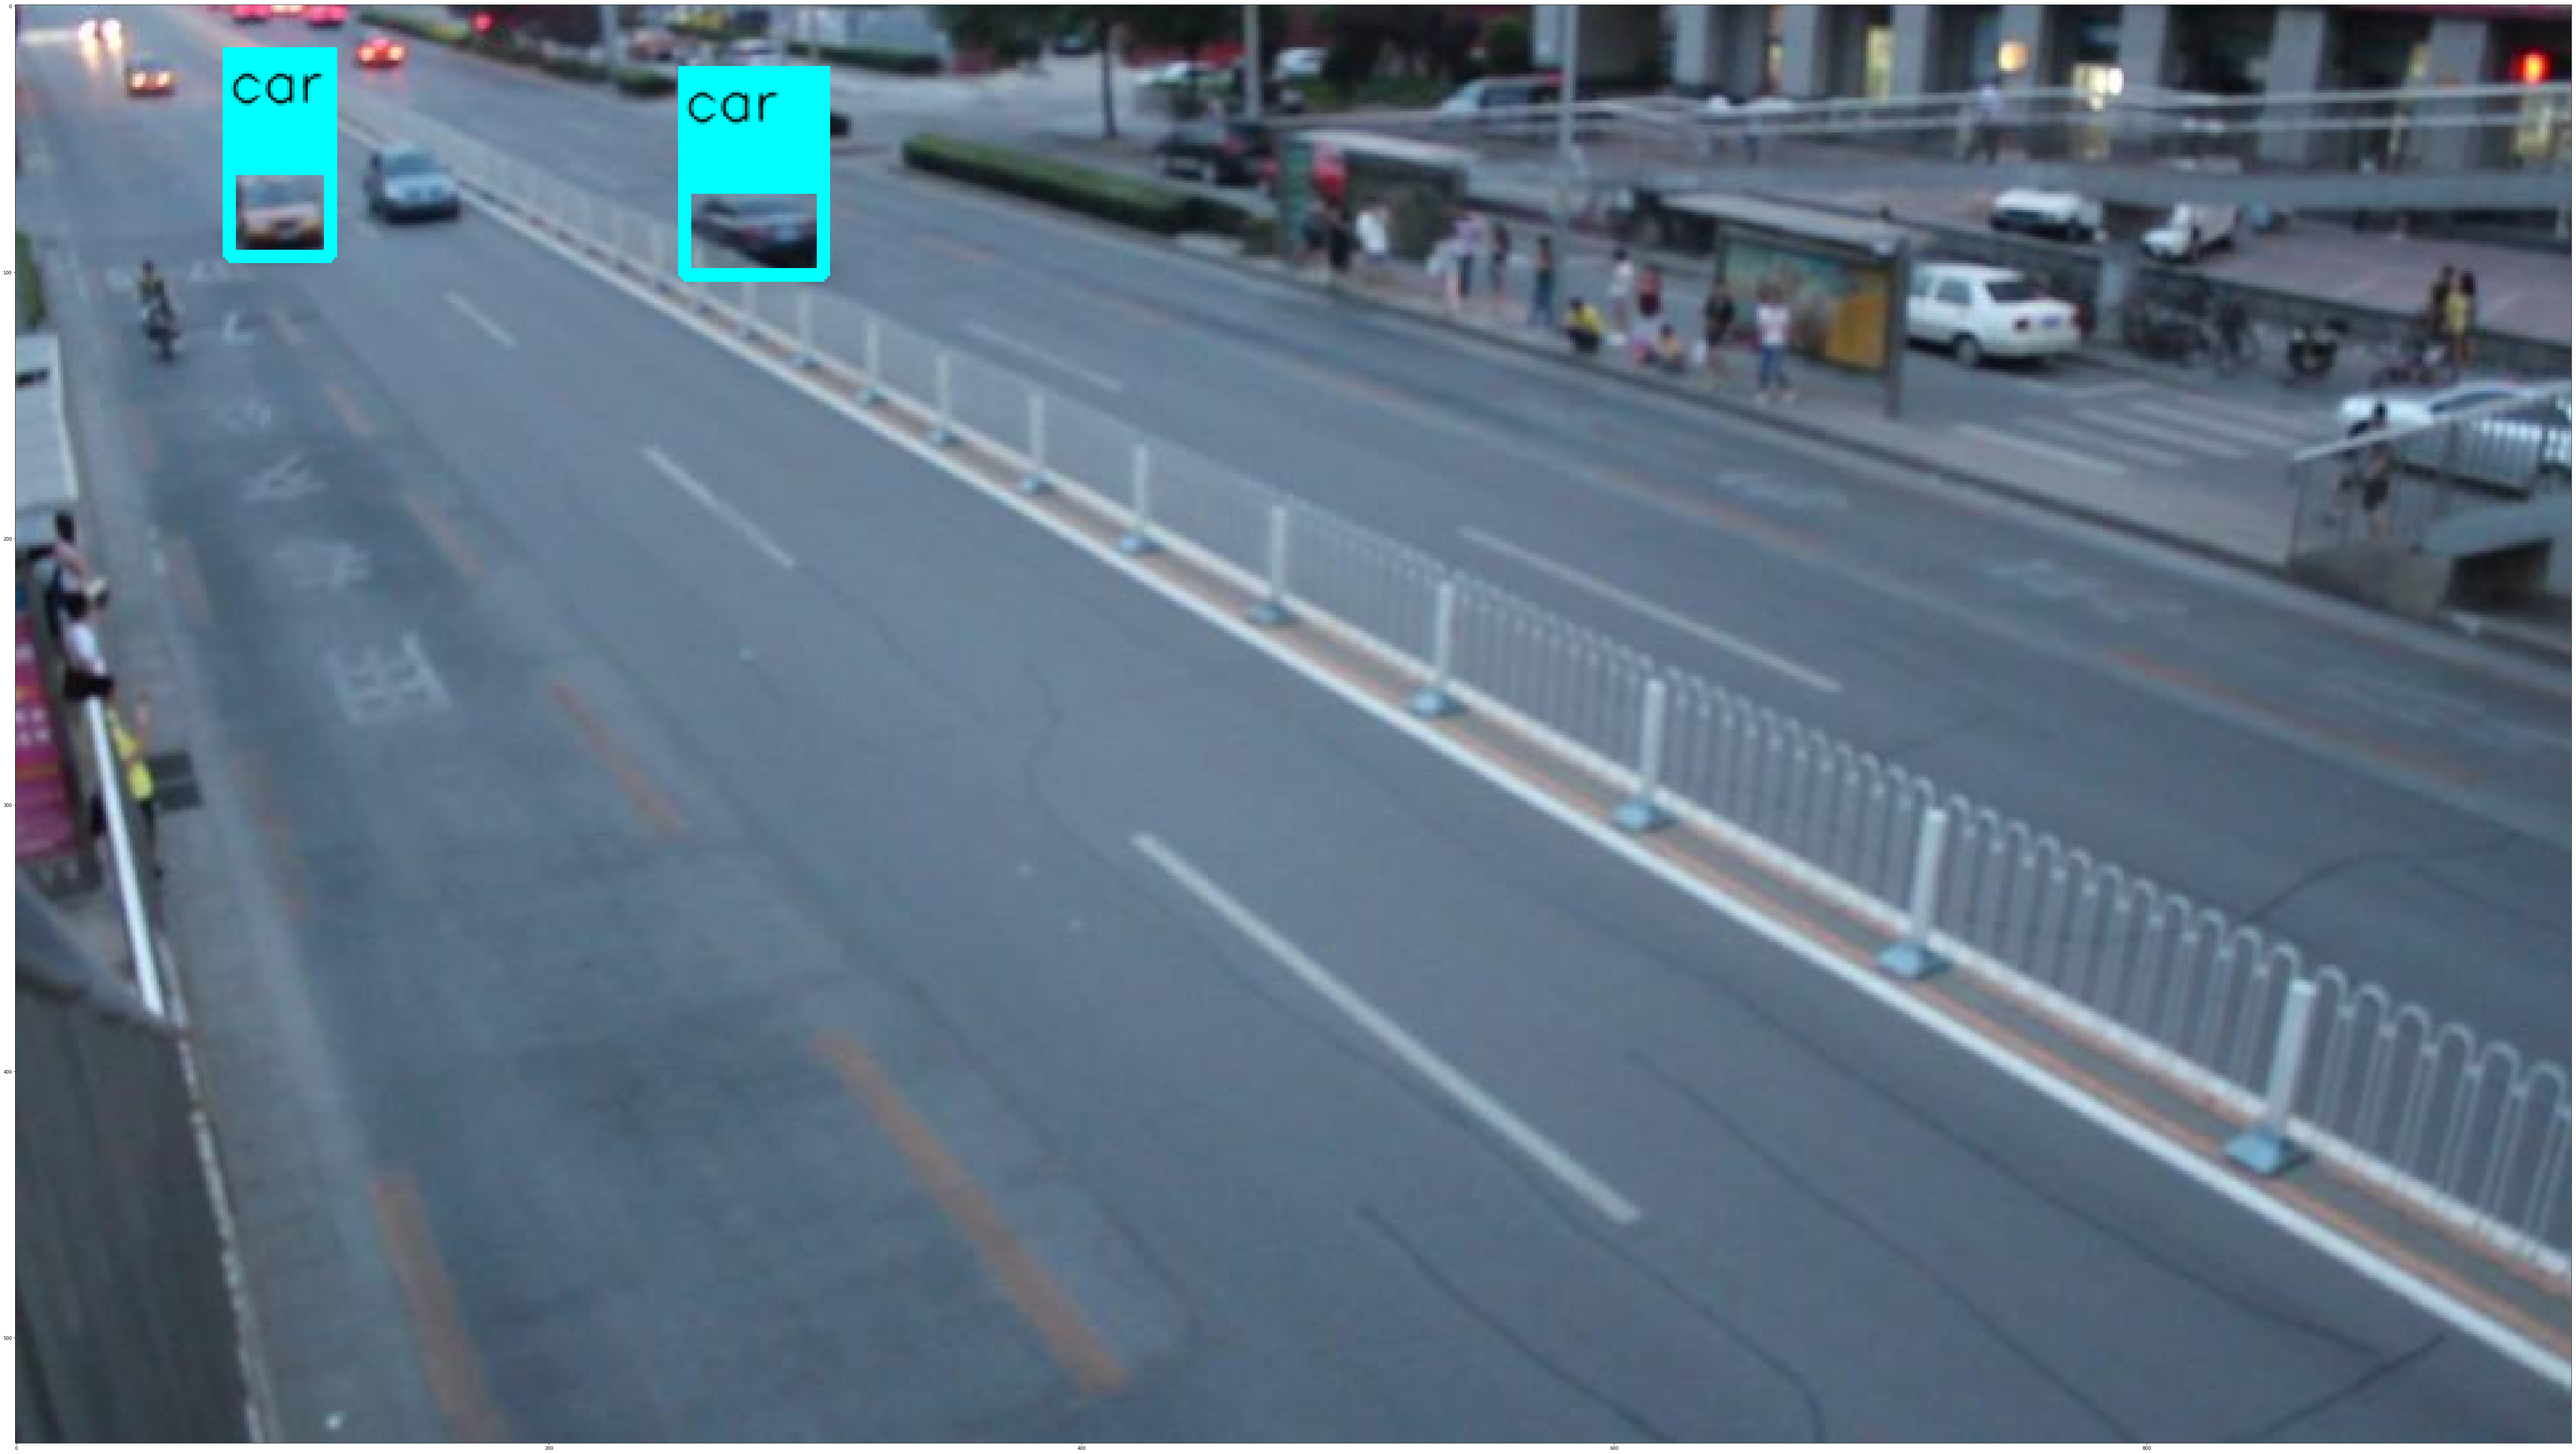

In [21]:
img = ua_imgs[476]
test_1 = cv2.imread(img['filename'])
test_1 = cv2.cvtColor(test_1, cv2.COLOR_BGR2RGB)
for obj in img['object']:
    test_1 = draw_box_label(test_1, [obj['ymin'], obj['xmin'], obj['ymax'], obj['xmax']], obj['name'], box_color=(0, 255, 255),show_label=True)
plt.figure(figsize=(100,100))
plt.imshow(test_1)
plt.show()